In [37]:
from typing import Union, List
from openai import OpenAI

MODEL_NAME = "gpt-4o"  # Default model name



def run_openai_query(query: Union[str, List[str]], use_tools: bool = False):
        
    
    client = OpenAI()
    if isinstance(query, str):
        if use_tools:
            response = client.responses.create(
                model=MODEL_NAME,
                tools=[{"type": "web_search_preview"}],
                input=f"{query}",
            )
        else:
            response = client.responses.create(
                model=MODEL_NAME,
                input=f"{query}",
            )
    else:
        chat_response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=query,
        )
        response = chat_response.choices[0].message.content
        
    return response


In [38]:
import os
import re
from typing import List, Dict, Union
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from LughaatNLP import LughaatNLP
from tqdm.auto import tqdm
from conllu import parse_incr, TokenList
from datasets import load_dataset


# --- Oracle function (assumed to exist elsewhere) ---
# def get_topic_name(words: List[str]) -> str:
#     """Returns a human-readable name for a topic given its top words."""
#     ...

def preprocess_urdu_doc(doc: str) -> List[str]:
    """Tokenize, lowercase, remove stopwords and short tokens for Urdu."""
    # Assuming a similar preprocessing function exists for Urdu
    urdu_text_processing = LughaatNLP()
    normalized_text = urdu_text_processing.normalize(doc)
    lemmatized_sentence = urdu_text_processing.lemmatize_sentence(normalized_text)
    stemmed_sentence = urdu_text_processing.urdu_stemmer(lemmatized_sentence)
    filtered_text = urdu_text_processing.remove_stopwords(stemmed_sentence)
    tokenized_text = urdu_text_processing.urdu_tokenize(filtered_text)
    
    return tokenized_text


def preprocess(doc: str, language='en') -> List[str]:
    """Tokenize, lowercase, remove stopwords and short tokens."""
    if language == 'ur':
        return preprocess_urdu_doc(doc)
    return [
        token
        for token in simple_preprocess(doc, deacc=True)
        if token not in STOPWORDS and len(token) > 3
    ]




def read_conllu(file_path: str) -> List[TokenList]:
    """
    Reads a CoNLL-U file and returns a list of conllu.TokenList objects,
    one per sentence. Each TokenList behaves like a list of dicts, where
    each dict has keys: 'id', 'form', 'lemma', 'upos', 'xpos', 'feats',
    'head', 'deprel', 'deps', and 'misc'.
    
    Args:
        file_path: path to the .conllu file
        
    Returns:
        List of TokenList, each representing one sentence.
    """
    docs: List[TokenList] = []
    with open(file_path, "r", encoding="utf-8") as f:
        for token_list in parse_incr(f):
            docs.append(token_list)
    return docs


def get_conll_doc_texts(conllu_path: str) -> List[str]:
    """
    Reads a CoNLL-U file and returns the text of each sentence.
    
    - If the CoNLL-U has a metadata line `# text = …`, that exact string is used.
    - Otherwise, tokens are joined by spaces to reconstruct the sentence.
    """
    docs = read_conllu(conllu_path)
    texts = []
    for doc in docs:
        # Check for metadata line first
        if 'text' in doc.metadata:
            texts.append(doc.metadata['text'])
        else:
            # Join tokens by space if no metadata text
            texts.append(" ".join(token['form'] for token in doc))
    return texts


def get_language_conllu_code(language: str) -> str:
    """
    Returns the CoNLL-U language code for a given language.
    
    Args:
    """
    if language == "ur":
        language = "ur_udtb"
    elif language == "en":
        language = "en_ewt"
    elif language == "fr":
        language = "fr_gsd"
    elif language == "de":
        language = "de_gsd"
    elif language == "es":
        language = "es_gsd"
    elif language == "ar":
        language = "ar_padt"
    elif language == "hi":
        language = "hi_hdtb"
    elif language == "zh":
        language = "zh_gsd"
    elif language == "ru":
        language = "ru_syntagrus"
    elif language == "ja":
        language = "ja_gsd"
    elif language == "ko":
        language = "ko_gsd"
    elif language == "it":
        language = "it_isdt"
    elif language == "pt":
        language = "pt_bosque"
    elif language == "tr":
        language = "tr_imst"
    else:
        raise ValueError(f"Unsupported language: {language}. Please provide a valid language code.")
    return language


def load_conll_data(language: str = "en") -> List[str]:
    """Loads CoNLL data for a given language."""
    # Load other languages' CoNLL data
    # Note: You can specify other language codes as needed
    # e.g., "en_ewt" for English, "fr_gsd"
    # or any other language supported by Universal Dependencies
    # For example, "en_ewt" for English EWT treebank
    # or "fr_gsd" for French GSD treebank
    # Adjust the language code as needed
    ud = load_dataset("universal_dependencies", get_language_conllu_code(language))

    splits = {
        "train": ud["train"],
        "validation": ud.get("validation", ud.get("dev")),
        "test": ud["test"],
    }
    
    return sum([d["text"] for d in splits.values()], [])


def read_folder_files(
    folder_path: str,
    file_extension: str = ".txt",
    threshold: float = 0.7
) -> List[str]:
    """Reads all files with a given extension from a folder."""

    # compile once: Unicode ranges covering Urdu/Arabic script
    URDU_RE = re.compile(r'[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF]')

    def is_mostly_urdu(line: str, threshold: float = 0.7) -> bool:
        """
        Check if the majority of non-whitespace characters in `line` are Urdu.
        
        Args:
            line:    input string (one line of text)
            threshold: fraction (0-1) above which we consider it "mostly Urdu"
                    (default 0.5)
        
        Returns:
            True if (Urdu_chars / non_space_chars) > threshold.
        """
        # count non-whitespace chars
        non_space_chars = [c for c in line if not c.isspace()]
        total = len(non_space_chars)
        if total == 0:
            return False
        
        # count Urdu script chars
        urdu_count = sum(bool(URDU_RE.match(c)) for c in non_space_chars)
        
        return (urdu_count / total) > threshold

    
    documents = []
    for filename in os.listdir(folder_path):
        if file_extension in ['.conll', '.conllu'] and filename.endswith(file_extension):
            sentences = get_conll_doc_texts(os.path.join(folder_path, filename))
            documents.extend(sentences)
        
        elif filename.endswith(file_extension):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                doc = f.read().replace("www.emarsiya.com", "")
                doc = "\n\n".join(
                    "\n".join([line for line in paragraph.split("\n") if is_mostly_urdu(line, threshold=threshold)]) 
                    for paragraph in doc.split("\n\n")
                )
                documents.append(doc.strip())
    return documents


def get_documents_data(
    docs_path: str = None, 
    file_extension: str = ".conllu",
    threshold: float = 0.7,
    use_ud: Union[bool, None] = None, 
    language='en'
):
    assert use_ud in [None, True, False], "use_ud must be None, True, or False"
    assert use_ud is not None or isinstance(docs_path, str), "If use_ud is None, docs_path must be a string path to a folder."
    if use_ud:
        # Load CoNLL data for Urdu
        documents = load_conll_data(language=language)
    if isinstance(docs_path, str):
        documents = read_folder_files(docs_path, file_extension=file_extension, threshold=threshold)
    
    print(f"Loaded {len(documents)} documents from {docs_path} with extension {file_extension}.")
    assert len(documents) > 0, "No documents loaded. Check the path and file extension."
    
    texts = [preprocess(doc, language) for doc in tqdm(documents, desc="Preprocessing documents")]
    
    return texts

In [43]:
def train_lda_and_name_topics(
    texts: List[str],
    num_topics: int = 10,
    topn: int = 50,
    no_below: int = 5,
    no_above: float = 0.5
) -> Dict[int, str]:
    """
    Given raw documents, trains an LDA model and returns a mapping
    from topic IDs to human-readable topic names.
    """
    # 1. Preprocessing

    # 2. Build dictionary & filter extremes
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)  # adjust thresholds as needed

    # 3. Build corpus
    corpus = [dictionary.doc2bow(text) for text in texts]

    # 4. Train LDA
    lda = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=10,
        random_state=42,
    )

    # 5. Extract top words and name topics
    topic_names: Dict[int, str] = {}
    for topic_id in range(num_topics):
        top_words_and_scores = lda.show_topic(topic_id, topn=topn)
        top_words = [word for word, score in top_words_and_scores]
        name = get_topic_name(top_words)
        topic_names[topic_id] = name

    return {
        'lda': lda,
        'dictionary': dictionary,
        'names': topic_names,
    }


def get_topic_name(words: List[str]) -> str:
    messages = [ 
        {
            "role": "system",
            "content": "You are a topic modeling naming assistant. "
            "Your task is to provide concise, human-readable names for topics based on their top words.",
        }, 
        {
        "role": "user",
        "content":
            f"Topic words: {', '.join(words)}"
            "Please provide a human-readable name for this topic."
        }
    ]
    
    topic = run_openai_query(messages, use_tools=False)
    return topic.strip() if topic else "Unnamed Topic"


def run_lda_and_name_topics(
    documents: List[List[str]],
    num_topics: int = 3, 
    topn: int = 50
) -> Dict[int, str]:
    """ Trains an LDA model on a set of documents and names the topics."""
    # Example usage:
    
    lda_output = train_lda_and_name_topics(
        texts=documents, 
        num_topics=num_topics, 
        topn=topn
    )
    
    for tid, tname in lda_output['names'].items():
        print(f"Topic {tid+1}: {tname}")
    
    return lda_output


In [50]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull


def plot_w2v_topics_3d(lda_output, docs, num_topics=5, topn=10):
    """
    Plots LDA topics in 3D using Word2Vec embeddings.
    
    Args:
        lda_output: output from run_lda_and_name_topics
        docs: list of preprocessed documents
        num_topics: number of topics to visualize
    """
    # 1) Get top words for each topic

    topn = 10
    topic_words = dict()
    for t in range(num_topics):
        topic_words[t] = [word for word, _ in lda_output['lda'].show_topic(t, topn)]

    w2v = Word2Vec(sentences=docs, vector_size=100, window=5,
                min_count=5, workers=4, seed=42)

    # 6) Gather embeddings for all topic words
    all_words = [w for words in topic_words.values() for w in words]
    unique_words = [w for w in dict.fromkeys(all_words) if w in w2v.wv]
    embs = np.stack([w2v.wv[w] for w in unique_words])

    # 7) Project to 3D
    pca = PCA(n_components=3, random_state=42)
    coords3d = pca.fit_transform(embs)
    word2coord = {w: coords3d[i] for i, w in enumerate(unique_words)}

    # 8) Plot in 3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = plt.cm.tab10(np.linspace(0, 1, num_topics))

    for t in range(num_topics):
        words = [w for w in topic_words[t] if w in word2coord]
        pts = np.array([word2coord[w] for w in words])

        # scatter points
        ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2],
                color=colors[t], s=50, label=f"Topic {t}")

        # annotate each point with its word
        for w, (x, y, z) in zip(words, pts):
            ax.text(x, y, z, w, fontsize=9, color=colors[t])

        # optional: draw convex hull around the cluster
        if len(pts) >= 4:
            hull = ConvexHull(pts)
            for simplex in hull.simplices:
                seg = pts[simplex]
                ax.plot(seg[:, 0], seg[:, 1], seg[:, 2],
                        color=colors[t], alpha=0.4)

    ax.set_title("LDA Topics + Word2Vec in 3D (PCA Projection)")
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()


def plot_w2v_topics_2d(lda_output, docs, num_topics=5, topn=10):
    """
    Plots LDA topics in 2D using Word2Vec embeddings.
    
    Args:
        lda_output: output from run_lda_and_name_topics
        texts: list of preprocessed documents
        num_topics: number of topics to visualize
    """
    # 5. Extract top-n words per topic
    topic_words = []
    for t in range(num_topics):
        topic_words.append([word for word, _ in lda_output['lda'].show_topic(t, topn)])

    # 6. Train Word2Vec on the same corpus
    w2v_model = Word2Vec(sentences=docs, vector_size=100, window=5,
                        min_count=5, workers=4, seed=42)

    # 7. Collect vectors for all topic words
    all_words = set(sum(topic_words, []))
    word_vecs = {w: w2v_model.wv[w] for w in all_words if w in w2v_model.wv}

    # 8. Dimensionality reduction (PCA to 2D)
    pca = PCA(n_components=2, random_state=42)
    X = pca.fit_transform(list(word_vecs.values()))
    words = list(word_vecs.keys())

    # 9. Plot
    plt.figure(figsize=(10, 8))
    colors = plt.cm.tab10.colors  # up to 10 distinct colors

    for topic_idx, words_in_topic in enumerate(topic_words):
        xs, ys = [], []
        for w in words_in_topic:
            if w in word_vecs:
                idx = words.index(w)
                xs.append(X[idx, 0])
                ys.append(X[idx, 1])
                plt.text(X[idx, 0], X[idx, 1], w, fontsize=12,
                        color=colors[topic_idx % len(colors)])
        # draw convex hull / polygon around the cluster (optional)
        if len(xs) >= 3:
            from scipy.spatial import ConvexHull
            points = list(zip(xs, ys))
            hull = ConvexHull(points)
            hull_pts = [points[v] for v in hull.vertices] + [points[hull.vertices[0]]]
            hx, hy = zip(*hull_pts)
            plt.plot(hx, hy, color=colors[topic_idx % len(colors)], alpha=0.5)

    plt.title("LDA + Word2Vec Topic Visualization")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()


Loaded 241 documents from ../datasets/marsiya-all with extension .txt.


Preprocessing documents:   0%|          | 0/241 [00:00<?, ?it/s]

Topic 1: پیغام و رسالت
Topic 2: Urdu Language Usage
Topic 3: "Existential Questions and Observations"
Topic 4: Battle of Karbala and the Role of Hazrat Abbas
Topic 5: "Prison and Suffering"


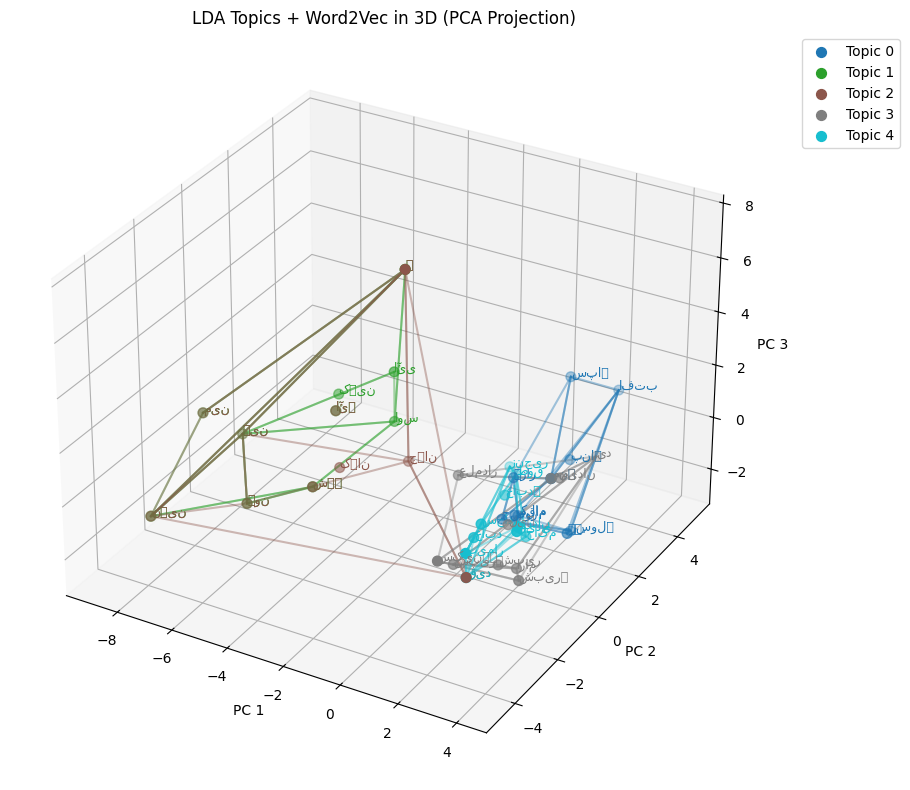

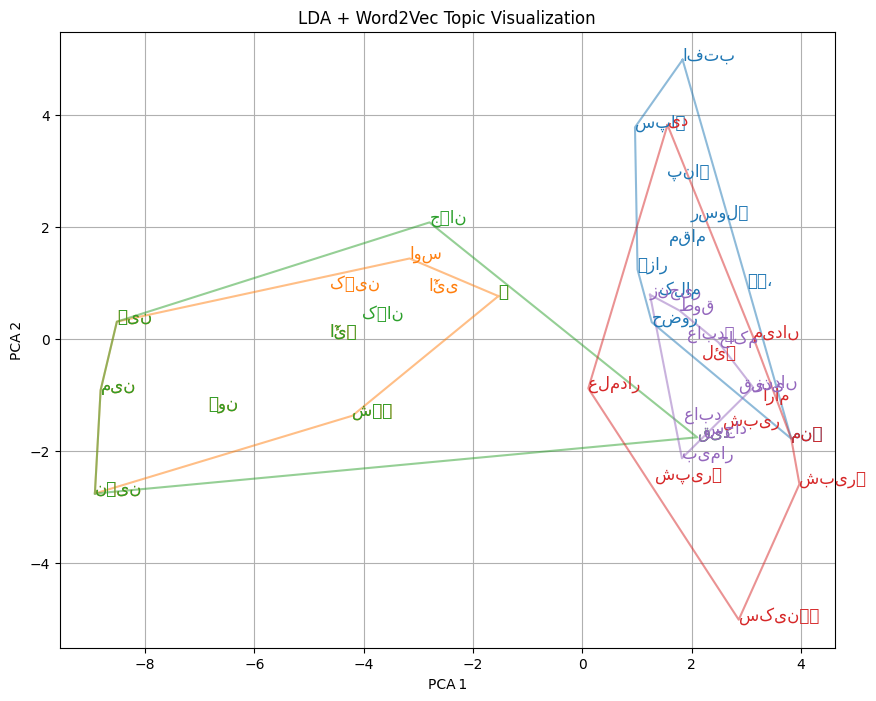

In [53]:
num_topics = 5
topn = 10
language = "ur"  # Change to "ur" for Urdu. Default is "en" for English.
use_ud = False  # Set to True to use Universal Dependencies data directly from internet. False if you have local .conllu files.
docs_path = "../datasets/marsiya-all"  # Change to path/to/your/urdu/documents with .txt or .conllu files
file_extension = ".txt"  # Change to ".conllu" if you have CoNLL-U files



docs = get_documents_data(
    docs_path=docs_path,
    file_extension=file_extension,
    use_ud=use_ud, 
    language=language
)

lda_output = run_lda_and_name_topics(
    documents=docs,
    num_topics=num_topics, 
    topn=topn
)

plot_w2v_topics_3d(lda_output, docs, num_topics=num_topics, topn=topn)
plot_w2v_topics_2d(lda_output, docs, num_topics=num_topics, topn=topn)